# Tune Matching

In the following example some gradient errors will be introduced to quadrupoles and then the tunes will be rematched to their original values by varying the strength of horizontally focusing quadrupoles. To begin with we load the example MADX script:

In [ ]:
with open('example.madx') as fh:
    script = fh.read()

As mentioned already, the script assigns gradient errors to all 18 quadrupoles and then varies the strength of the 12 horizontal quadrupoles in order to rematch the tune. Let's inspect the results by running the script via `dipas.madx.run_script`:

In [2]:
import os
from dipas.madx import run_script

result = run_script(
    script,
    {'twiss': True, 'twiss_error': True, 'twiss_matched': True, 'errors': False},
    madx=os.path.expanduser('~/bin/madx')
)
twiss = result['twiss']
twiss_error = result['twiss_error']
twiss_matched = result['twiss_matched']
errors = result['errors']

/home/dominik/Projects/DiPAS/dipas/madx/utils.py:247: UserWarning: MADX issued the following warnings: ['MTSIMP More variables than constraints seen. SIMPLEX may not converge to optimal solution.']
  warnings.warn(f'MADX issued the following warnings: {warnings_list}')


Here we specified `True` for the twiss files since we want to retrieve the "@"-prefixed meta data besides the actual data frame (since the meta data contains the tune values). For the errors file we're not interested in meta data and so `False` will result in just the corresponding data frame. Let's inspect the tune values:

In [3]:
print('Tune values:')
print(f' - original: {        twiss[1]["Q1"]:.3f}, {        twiss[1]["Q2"]:.3f}')
print(f' - shifted : {  twiss_error[1]["Q1"]:.3f}, {  twiss_error[1]["Q2"]:.3f}')
print(f' - matched : {twiss_matched[1]["Q1"]:.3f}, {twiss_matched[1]["Q2"]:.3f}')

Tune values:
 - original: 2.420, 2.420
 - shifted : 2.362, 2.459
 - matched : 2.420, 2.420


Now let's do the same thing with gradient-based optimization via DiPAS. First we load the script via `dipas.build.from_script` and assign the errors via the `errors` data frame:

In [4]:
from dipas.build import from_script

lattice = from_script(script, errors=errors)

We select the quadrupoles by checking for `k1 != 0` since the script defines drift spaces as `k1 == 0` quadrupoles:

In [5]:
from dipas.elements import Quadrupole, Parameter

quadrupoles = [q for q in lattice[Quadrupole] if q.k1 != 0]
for q in quadrupoles:
    print(f'{q.label}, k1 = {q.k1: .6f}, dk1 = {q.dk1: .6f}')

yr02qs1, k1 =  1.760051, dk1 = -0.013478
yr02qs2, k1 = -2.252993, dk1 =  0.012333
yr02qs3, k1 =  1.760051, dk1 = -0.077924
yr04qs1, k1 =  1.760051, dk1 = -0.003707
yr04qs2, k1 = -2.252993, dk1 =  0.047466
yr04qs3, k1 =  1.760051, dk1 =  0.035394
yr06qs1, k1 =  1.760051, dk1 = -0.144814
yr06qs2, k1 = -2.252993, dk1 = -0.069407
yr06qs3, k1 =  1.760051, dk1 = -0.069233
yr08qs1, k1 =  1.760051, dk1 =  0.055320
yr08qs2, k1 = -2.252993, dk1 = -0.008849
yr08qs3, k1 =  1.760051, dk1 =  0.001484
yr10qs1, k1 =  1.760051, dk1 = -0.086816
yr10qs2, k1 = -2.252993, dk1 = -0.001718
yr10qs3, k1 =  1.760051, dk1 = -0.015357
yr12qs1, k1 =  1.760051, dk1 = -0.096350
yr12qs2, k1 = -2.252993, dk1 = -0.068815
yr12qs3, k1 =  1.760051, dk1 =  0.135457


For the matching we will use the horizontally focusing quadrupoles and so we'll select these and turn their `k1` attributes into parameters (being varied during the optimization). We have to call `update_transfer_map` as well in order for the change to `k1` to become effective. In general, after altering any (to-be-)parametrized attribute of a lattice element (also its value), we need to call the `update_transfer_map` method for bringing the change into effect.

In [6]:
h_quadrupoles = [q for q in quadrupoles if q.k1 > 0]
for q in h_quadrupoles:
    q.k1 = Parameter(q.k1)
    q.update_transfer_map()
print(f'# Parameters: {len(list(lattice.parameters()))}')

# Parameters: 12


Next we'll prepare the optimization by creating an optimizer and defining a cost (loss) function. The cost function indicates the distance to the optimization target(s). Before we can use the lattice's transfer maps we need to convert `Kicker` elements to thin counterparts since the transfer map for a thick kicker doesn't exist. We specify two slices placed at the edges of the original elements (this is the configuration used by MADX during TWISS computation).

We use the `dipas.compute.twiss` function for computing the tune values (alongside other lattice functions). When computing the gradients via `cost.backward` we specify `retain_graph=True` since at every iteration we're optimizing against the same data and so retaining the graph is required (e.g. the transfer map tensors of lattice elements will be reused at every iteration so their memory buffers need to be retained). At the end of each iteration, after the optimizer has updated the `k1` values, we need to call `update_transfer_map` again in order to activate the updates.

In [7]:
import itertools as it
import dipas.compute as compute
from dipas.elements import Kicker
import torch

lattice = lattice.makethin({Kicker: 2}, style={Kicker: 'edge'})
print(f'# Parameters: {len(list(lattice.parameters()))}')

targets = {'Q1': torch.tensor(twiss[1]['Q1']), 'Q2': torch.tensor(twiss[1]['Q2'])}
optimizer = torch.optim.LBFGS(lattice.parameters())
cost_fn = torch.nn.MSELoss()

for step in it.count():
    def closure():
        optimizer.zero_grad()
        data = compute.twiss(lattice)
        Q1, Q2 = data['Q1'], data['Q2']
        cost = cost_fn(Q1, targets['Q1']) + cost_fn(Q2, targets['Q2'])
        print(f'Step {step:03d}: Q1 = {Q1:.3f}, Q2 = {Q2:.3f}, cost = {cost:.2e}')
        if cost < 1e-6:
            raise RuntimeError
        cost.backward(retain_graph=True)
        return cost
    
    try:
        optimizer.step(closure)
    except RuntimeError:
        break
        
    for q in h_quadrupoles:
        q.update_transfer_map()

# Parameters: 12
Step 000: Q1 = 2.362, Q2 = 2.459, cost = 4.88e-03
Step 000: Q1 = 2.362, Q2 = 2.459, cost = 4.88e-03
Step 001: Q1 = 2.386, Q2 = 2.446, cost = 1.87e-03
Step 001: Q1 = 2.386, Q2 = 2.446, cost = 1.87e-03
Step 002: Q1 = 2.408, Q2 = 2.435, cost = 3.69e-04
Step 002: Q1 = 2.408, Q2 = 2.435, cost = 3.69e-04
Step 003: Q1 = 2.418, Q2 = 2.430, cost = 1.10e-04
Step 003: Q1 = 2.418, Q2 = 2.430, cost = 1.10e-04
Step 004: Q1 = 2.422, Q2 = 2.428, cost = 7.26e-05
Step 004: Q1 = 2.422, Q2 = 2.428, cost = 7.26e-05
Step 005: Q1 = 2.423, Q2 = 2.428, cost = 6.80e-05
Step 005: Q1 = 2.423, Q2 = 2.428, cost = 6.80e-05
Step 006: Q1 = 2.424, Q2 = 2.427, cost = 6.25e-05
Step 006: Q1 = 2.424, Q2 = 2.427, cost = 6.25e-05
Step 007: Q1 = 2.425, Q2 = 2.425, cost = 5.13e-05
Step 007: Q1 = 2.425, Q2 = 2.425, cost = 5.13e-05
Step 008: Q1 = 2.425, Q2 = 2.423, cost = 3.71e-05
Step 008: Q1 = 2.425, Q2 = 2.423, cost = 3.71e-05
Step 009: Q1 = 2.424, Q2 = 2.422, cost = 1.66e-05
Step 009: Q1 = 2.424, Q2 = 2.422,

Now let's crosscheck the solution by running it through MADX. We can use `dipas.build.create_script` in order to convert the `lattice` object to a corresponding MADX script.

In [8]:
from dipas.build import create_script

twiss_check = run_script(
    create_script(sequence=lattice, errors=True, beam={'particle': 'proton', 'energy': 1}),
    twiss=True,
    madx=os.path.expanduser('~/bin/madx')
)['twiss']
print(f'Tune values: {twiss_check[1]["Q1"]:.3f}, {twiss_check[1]["Q2"]:.3f}')

Tune values: 2.420, 2.420


Finally let's compare the results to the solution which MADX originally computed:

In [9]:
import pandas as pd

q_names = [q.label.upper() for q in h_quadrupoles]
results = twiss_matched[0].set_index('NAME').loc[q_names, ['K1L']]
results = results.assign(DP=pd.Series([q.k1.item()*q.l.item() for q in h_quadrupoles], index=q_names))
results.columns = ['K1L_MADX', 'K1L_PF']
print(results)

         K1L_MADX    K1L_PF
NAME                       
YR02QS1  0.521336  0.517564
YR02QS3  0.513679  0.509166
YR04QS1  0.538908  0.530332
YR04QS3  0.517392  0.527857
YR06QS1  0.514691  0.513474
YR06QS3  0.513379  0.513102
YR08QS1  0.552487  0.526501
YR08QS3  0.533606  0.526681
YR10QS1  0.506585  0.515837
YR10QS3  0.507948  0.518586
YR12QS1  0.500134  0.513845
YR12QS3  0.500342  0.506482


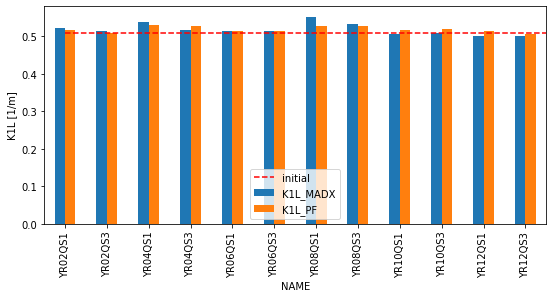

In [10]:
%matplotlib inline

ax = results.plot(kind='bar', figsize=(9, 4))
ax.set_ylabel('K1L [1/m]')
ax.plot([0, len(results)], [0.5086546699]*2, '--', color='red', label='initial')
ax.legend()